# **ch12 영화 추천시스템**
- **처음 배우는 머신러닝** 12장 : [**(GitHub)**](https://github.com/your-first-ml-book/Examples)
- 내용 기반의 영화추천 시스템
- 협업필터링 기반의 영화추천 시스템

## **1 데이터 입력 및 전처리**
### **01 데이터 불러오기**
Movie Lens [**(Web)**](https://grouplens.org/datasets/movielens/) 의 텍스트 데이터를 활용하여 분석을 진행합니다
- 데이터 정보를 List 로 저장
- 별점정보는 Numpy 다차원 배열로 저장
- 사용자 별점과, 영화별점의 편차를 측정

In [15]:
! cat ./data/ml-100k/u.user | head -n 2

1|24|M|technician|85711
2|53|F|other|94043


In [16]:
! cat ./data/ml-100k/u.data | head -n 2

196	242	3	881250949
186	302	3	891717742
cat: 쓰기 오류: 파이프가 깨어짐


In [17]:
! cat ./data/ml-100k/u.item | head -n 2

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
cat: 쓰기 오류: 파이프가 깨어짐


In [18]:
# 작업에 사용할 파일목록들을 연결합니다
fin_user   = "./data/ml-100k/u.user" # 사용자 개인정보
fin_movie  = "./data/ml-100k/u.item" # 영화정보
fin_rating = "./data/ml-100k/u.data" # 영화 별점정보

# 데이터셋 불러오기 (delim:구분자)
import codecs
def read_data(fin, delim):
    info_li = []
    for line in codecs.open(fin, "r", encoding="latin-1"):
        line_items = line.strip().split(delim)
        key        = int(line_items[0])
        if (len(info_li)+1) != key:
            print('errors at data_id'); exit(0)
        info_li.append(line_items[1:])
    print('{} 데이터의 행수: {:5,}'.format(fin, len(info_li)))
    return(info_li)

user_info_li  = read_data(fin_user, '|')
movie_info_li = read_data(fin_movie,'|')

./data/ml-100k/u.user 데이터의 행수:   943
./data/ml-100k/u.item 데이터의 행수: 1,682


In [19]:
# 영화 별점정보로 유틸리티 행렬 만들기
import numpy as np
def read_rating_data(fin):
    Q = np.zeros((len(user_info_li), len(movie_info_li)), dtype=np.float64)
    for line in open(fin):
        user, movie, rating, date = line.strip().split("\t")
        user_index  = int(user)  - 1
        movie_index = int(movie) - 1
        Q[user_index,movie_index] = float(rating)
    return(Q)

R = read_rating_data(fin_rating)
print("별점정보 영화 Matrix :", R.shape)

별점정보 영화 Matrix : (943, 1682)


### **02 데이터 전처리 후 통계적 분석**
- 기초통계량 모듈을 사용하여 데이터 분포를 분석합니다
- stats 모듈은 출력모양이 이쁘지 않아 사용자 정의함수로 출력합니다 [함수모음](https://www.programcreek.com/python/example/100345/scipy.stats.describe)

In [20]:
# 개별 사용자의 별점평균 List
from scipy import stats

user_mean_li = []
for i in range(0,R.shape[0]):
    user_rating = [x for x in R[i] if x>0.0]
    user_mean_li.append(stats.describe(user_rating).mean)

# 사용자 별점평균의 기초통계량 분석
def print_statistics(array, title=""):
    sta = stats.describe(array)
    print(title, "\n%14s %15s"%('statistic','value'), "\n", 30*'-', "\n%14s %15.5f"%('size',sta[0]),\
          "\n%14s %15.5f"%('min',sta[1][0]), "\n%14s %15.5f"%('max', sta[1][1]),\
          "\n%14s %15.5f"%('mean',sta[2]), "\n%14s %15.5f"%('std', np.sqrt(sta[3])),\
          "\n%14s %15.5f"%('skew',sta[4]), "\n%14s %15.5f"%('kutosis', sta[5])) 

print_statistics(user_mean_li, "<사용자별 별점평균 기초통계분석>")

<사용자별 별점평균 기초통계분석> 
     statistic           value 
 ------------------------------ 
          size       943.00000 
           min         1.49195 
           max         4.86957 
          mean         3.58819 
           std         0.44523 
          skew        -0.44417 
       kutosis         0.92868


In [21]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# 영화의 평균 별점 기초 통계량 구하기
movie_mean_li = []
for i in range(0, R.shape[1]):
    R_T = R.T
    movie_rating = [x  for x in R_T[i] if x>0.0]
    movie_mean_li.append(stats.describe(movie_rating).mean)

warnings.simplefilter('default')
print_statistics(movie_mean_li, "<영화별 별점평균 기초통계분석>")
# stats.describe(movie_mean_li)

<영화별 별점평균 기초통계분석> 
     statistic           value 
 ------------------------------ 
          size      1682.00000 
           min         1.00000 
           max         5.00000 
          mean         3.07604 
           std         0.78166 
          skew        -0.69913 
       kutosis         0.44420


## **2 내용기반 영화추천 시스템**
영화 줄거리의 **Tf-idf 코싸인 유사도를** 분석하여 측정
- **movie_info_li : 영화의 정보를** 저장 (한 영화당 **23가지 정보를** 포함)
- **movie_plot_li : 영화의 줄거리만** 저장
- 위 2개의 객체내 **정보수는 동일하므로** 필요에 따라 둘을 조합합니다
- **1,682개의** 전체가 아닌 **100개의 영화정보만** 사용하여 tf-idf 변환 후 추천알고리즘에 적용합니다

In [22]:
# 영화 플롯 데이터 호출 (예제 12-5, 12-6을 대체)
movie_plot_li =[]
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)
for line in open('./data/ml-100k-plot.txt'):
    try:
        ml_id, plot = line.strip().split('|',1)
        movie_plot_li.append(plot)            
    except ValueError:
        movie_plot_li.append('')

print("info, plot 갯수일치: {}\nmovie_plot_li[0]:{}\nmovie_plot_li[0]:{}".format(
    len(movie_plot_li) == len(movie_info_li),
    movie_info_li[0][:3], movie_plot_li[0][:80]))

info, plot 갯수일치: True
movie_plot_li[0]:['Toy Story (1995)', '01-Jan-1995', '']
movie_plot_li[0]:A little boy named Andy loves to be in his room, playing with his toys, especial


In [23]:
warnings.simplefilter(action='ignore', category=PendingDeprecationWarning)

# TF-IDF로 변환한 키워드의 리스트 (X의 0번 열 키워드는 feature_names[0])
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer    = TfidfVectorizer(min_df=3, stop_words='english')
X             = vectorizer.fit_transform(movie_plot_li[:100])
feature_names = vectorizer.get_feature_names()
warnings.simplefilter('default')
print(feature_names[:10])

['27', 'able', 'accident', 'action', 'affair', 'agent', 'alive', 'america', 'american', 'amy']


In [24]:
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=PendingDeprecationWarning)

# 사용자 정의 Tokenizer 정의
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl       = WordNetLemmatizer()
        # self.tokenizer = RegexpTokenizer('(?u)\w\w+')
        self.tokenizer = RegexpTokenizer('(?u)[A-z]+')
    
    # 클래스 객체를 호출시 마다 실행(Tf-idf Vector 키워드 호출)
    def __call__(self, doc): 
        return([self.wnl.lemmatize(t) for t in self.tokenizer.tokenize(doc)])

# 사이킷런에 위에서 정의한 토크나이저를 입력으로 넣습니다.
vectorizer2   = TfidfVectorizer(min_df=3, tokenizer=LemmaTokenizer(), stop_words='english')
X             = vectorizer2.fit_transform(movie_plot_li[:100])
feature_names = vectorizer2.get_feature_names()

/home/markbaum/Python/python/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [25]:
# 비슷한 영화 추천하기
from sklearn.metrics.pairwise import cosine_similarity
movie_sim = cosine_similarity(X)
print(movie_sim.shape)

def similar_recommend_by_movie_id(movielens_id):
    # enumerate 함수로 [(리스트 인덱스 0, 유사도 0), (리스트 인덱스 1, 유사도 1)...]의
    # 리스트를 만듭니다. 그 후 각 튜플의 두 번째 항목, 즉 유사도를 이용하여 내림차순 정렬합니다.
    # 이렇게 만든 리스트의 가장 앞 튜플의 첫 번째 항목이 영화 ID가 됩니다.
    movie_index    = movielens_id - 1
    similar_movies = sorted(list(enumerate(movie_sim[movie_index])),key=lambda x:x[1], reverse=True)
    recommended    = 1
    print("----- {} : 관람객 추천영화 ------".format(movie_info_li[movie_index][0]))
    for movie_info in similar_movies[1:8]:
        movie_title = movie_info_li[movie_info[0]] # 자신은 추천서 제외
        print('추천영화 %d순위 : %s'%(recommended, movie_title[0]))
        recommended += 1

similar_recommend_by_movie_id(1)

(100, 100)
----- Toy Story (1995) : 관람객 추천영화 ------
추천영화 1순위 : Santa Clause, The (1994)
추천영화 2순위 : What's Eating Gilbert Grape (1993)
추천영화 3순위 : Shawshank Redemption, The (1994)
추천영화 4순위 : Searching for Bobby Fischer (1993)
추천영화 5순위 : Seven (Se7en) (1995)
추천영화 6순위 : Aladdin (1992)
추천영화 7순위 : Batman Forever (1995)


In [26]:
similar_recommend_by_movie_id(22)

----- Braveheart (1995) : 관람객 추천영화 ------
추천영화 1순위 : Angels and Insects (1995)
추천영화 2순위 : Searching for Bobby Fischer (1993)
추천영화 3순위 : Priest (1994)
추천영화 4순위 : Three Colors: Blue (1993)
추천영화 5순위 : Batman Forever (1995)
추천영화 6순위 : Richard III (1995)
추천영화 7순위 : Legends of the Fall (1994)


## **3 협업 필터링 기반의 영화 추천 시스템**
### **01 특잇값 분해**
**mean_squared_error**(정답행렬, 근사행렬)
- 교대 최소제곱법
- 가중치 교대 최소제곱법
- 경사 하강법

In [13]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_error

# R(사용자 별점정보) 교대 최소제곱법 구현
def compute_ALS(R, n_iter:int, lambda_:float, k):
    '''임의의 사용자 행렬 X, 영화 행렬 Y를 생성한 뒤
    교대 최소제곱법을 이용하여 유틸리티 행렬 R을 근사합니다.
    :param R(ndarray)     : 유틸리티 행렬
    :param n_iter(fint)   : X와 Y 반복횟수
    :param lambda_(float) : 정규화 파라미터
    '''
    m, n         = R.shape
    X, Y, errors = np.random.rand(m, k), np.random.rand(k, n), [] # 갱신마다 에러저장
    for i in range(0, n_iter): # np.eye : n x n 크기 단위행렬
        X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(k), np.dot(Y, R.T)).T
        Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(k), np.dot(X.T, R))        
        errors.append(mean_squared_error(R, np.dot(X, Y)))
        if i % 10 == 0: print('{:3} 번 iteration 완료'.format(i))
    R_hat = np.dot(X, Y)
    print('MSE rate(작을수록 일치도 높음): %.5f'%(mean_squared_error(R, np.dot(X, Y))))
    return(R_hat, errors) # 생성한 배열과 오류값 출력합니다

# 검사행렬, 반복횟수, 변화율, 행렬의 크기
R_hat, errors = compute_ALS(R, 20, 0.1, 100)

  0 번 iteration 완료
 10 번 iteration 완료
MSE rate(작을수록 일치도 높음): 0.24661
CPU times: user 2.37 s, sys: 1.46 s, total: 3.83 s
Wall time: 1.01 s


In [14]:
%%time
# 가중치 교대 최소제곱법 구현 (가중치 행렬을 mean_squared_error 함수의 인자로 사용) 
def compute_wALS(R,W, n_iter, lambda_, k):
    m, n = R.shape
    weighted_errors = []
    X, Y = np.random.rand(m, k), np.random.rand(k, n)
    
    for ii in range(n_iter): # 가중치 행렬을 넣어서 계산 (사용자와 영화 가중치 행렬로 X와 Y를 갱신)
        for u, Wu in enumerate(W):
            X[u,:] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) +\
                                     lambda_ * np.eye(k), np.dot(Y, np.dot(np.diag(Wu),R[u,:].T))).T
        for i, Wi in enumerate(W.T):
            Y[:, i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) +\
                                      lambda_ * np.eye(k), np.dot(X.T, np.dot(np.diag(Wi), R[:, i])))
        
        weighted_errors.append(mean_squared_error(R, np.dot(X, Y),sample_weight=W))
        if ii % 3 == 0: print('{:3} 번 iteration 완료'.format(ii))
    
    R_hat = np.dot(X, Y)
    print('MSE rate(작을수록 일치도 높음): %.5f'%(mean_squared_error(R, np.dot(X, Y), sample_weight=W)))
    return(R_hat, errors)

# R 테이블의 가중치 행렬을 생성후 계산을 한다 (별점 존재시1, 별점 없으면0)
W                            = R > 0.0
W[W == True], W[W == False]  = 1, 0
W                            = W.astype(np.float64, copy=False)
R_hat, errors                = compute_wALS(R, W, 20, 0.1, 100)

  0 번 iteration 완료
  3 번 iteration 완료
  6 번 iteration 완료
  9 번 iteration 완료
 12 번 iteration 완료
 15 번 iteration 완료
 18 번 iteration 완료
MSE rate(작을수록 일치도 높음): 0.00064
CPU times: user 33min 17s, sys: 8min 17s, total: 41min 34s
Wall time: 11min 3s


In [15]:
%%time
# 경사하강법 구현
def compute_GD(R,n_iter, lambda_, learning_rate, k):
    m,n    = R.shape
    errors = []
    X, Y   = np.random.rand(m, k), np.random.rand(k, n)
    for ii in range(n_iter):   # 입력받은 반복 횟수만큼 갱신을 반복
        for u in range(m):
            for i in range(n):
                if R[u,i] > 0: # 각 사용자 및 상품의 행렬에 대해 하나씩 계산
                    e_ui   = R[u,i]-np.dot(X[u, :], Y[:,i])
                    X[u,:] = X[u,:] + learning_rate * (e_ui* Y[:,i] - lambda_ * X[u,:])
                    Y[:,i] = Y[:,i] + learning_rate * (e_ui * X[u,:] - lambda_ * Y[:,i])                      
        errors.append(mean_squared_error(R, np.dot(X, Y)))
        if ii % 10 == 0: print('{:3} 번 iteration 완료'.format(ii))

    R_hat = np.dot(X, Y)
    print('MSE rate(작을수록 일치도 높음): %.5f'%(mean_squared_error(R, R_hat)))
    return(R_hat, errors)

R_hat, errors= compute_GD(R, 20, 1, 0.001, 100)

  0 번 iteration 완료
 10 번 iteration 완료
MSE rate(작을수록 일치도 높음): 25.64681
CPU times: user 49.8 s, sys: 4.12 s, total: 53.9 s
Wall time: 48 s


In [16]:
R_hat, errors= compute_GD(R, 40, 1, 0.001, 100)

  0 번 iteration 완료
 10 번 iteration 완료
 20 번 iteration 완료
 30 번 iteration 완료
MSE rate(작을수록 일치도 높음): 17.69667


### **02 근사 모델의 생성 및 평가**
- R 테이블의 일부분을 학습한 결과가 **OverFitting** 의 문제를 발생
- 보다 일반화된 모델을 얻기 위해 **학습데이터와 평가데이터를** 나눠서 학습

In [17]:
# 학습-평가 데이터 나누기
def train_test_split(R, n_test):
    train = R.copy()
    test  = np.zeros(R.shape)
    for user in range(R.shape[0]):
        test_index = np.random.choice(R[user, :].nonzero()[0], size=n_test, replace=False)
        train[user, test_index] = 0.
        test[user, test_index]  = R[user, test_index]
    return (train, test)

# 예제 12-13
def get_test_mse(true,pred):
    # 0이 아닌 값만 이용해 에러를 계산(true:평가 데이터, pred:학습 데이터)
    pred = pred[true.nonzero()].flatten()
    true = true[true.nonzero()].flatten()
    return mean_squared_error(true,pred)

In [25]:
%%time
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_ALS(R, test, n_iter, lambda_, k):
    '''임의의 사용자 요인 행렬 X와 임의의 영화 요인 행렬 Y를 생성하고 교대 최소제곱법을 이용하여
    유틸리티 행렬 R을 근사합니다. 그후 test행렬을 이용하여 평가합니다.
    R(ndarray) : 유틸리티 행렬
    test: 평가행렬
    lambda_(float) : 정규화 파라미터
    n_iter(fint) : X와 Y의 갱신 횟수
    '''
    m,n  = R.shape
    X, Y, errors = np.random.rand(m, k), np.random.rand(k, n), []
    for i in range(0, n_iter): # 갱신 시마다 계산한 에러를 저장
        X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(k),np.dot(Y, R.T)).T
        Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(k), np.dot(X.T, R))
        errors.append(get_test_mse(test,np.dot(X, Y)))
        if i % 10 == 0: print('{:3} 번 iteration 완료'.format(i))
    R_hat = np.dot(X, Y)
    print('MSE rate(작을수록 일치도 높음): %.5f'%(get_test_mse(test, R_hat)))
    return(R_hat, errors)


train,test          = train_test_split(R, 10)
# 생성한 근사 Matrix와 train 데이터 Set 일치도
R_hat, train_errors = compute_ALS(train, train, 20, 0.1,100)

  0 번 iteration 완료
 10 번 iteration 완료
MSE rate(작을수록 일치도 높음): 2.38620
CPU times: user 3.16 s, sys: 2.07 s, total: 5.22 s
Wall time: 1.37 s


In [26]:
# 생성한 근사 Matrix와 test 데이터 Set 일치도
R_hat, test_errors = compute_ALS(train, test,20, 0.1,100)

  0 번 iteration 완료
 10 번 iteration 완료
MSE rate(작을수록 일치도 높음): 10.06186


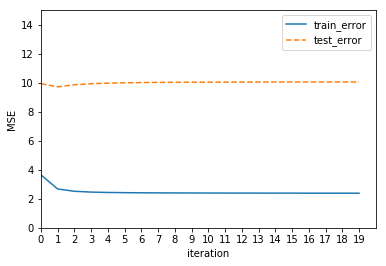

In [27]:
# 반복에 따른 학습-평가 에러변화 출력(평가에러: 점선, 학습에러: 실선)
# 1회 학습후 test 오류가 늘어나는 모습으로 OverFit을 의심가능
from matplotlib import pyplot as plt
x = range(0,20)
plt.xlim(0,20); plt.xlabel('iteration'); plt.xticks(x, range(0,20));
plt.ylim(0,15); plt.ylabel('MSE')
plt.plot(x,train_errors,      label='train_error')
plt.plot(x,test_errors, '--', label='test_error')
plt.legend()#handles=[train_plot, test_plot])
plt.show()

In [21]:
%%time
# 정규화 파라미터를 50으로 학습한 경우, 일반화 성능 개선여부
R_hat, train_errors = compute_ALS(train, train,20, 50,100)
R_hat, test_errors  = compute_ALS(train, test, 20, 50,100)

  0 번 iteration 완료
 10 번 iteration 완료
MSE rate(작을수록 일치도 높음): 5.46744
  0 번 iteration 완료
 10 번 iteration 완료
MSE rate(작을수록 일치도 높음): 9.07524
CPU times: user 10.3 s, sys: 7.35 s, total: 17.7 s
Wall time: 6.17 s


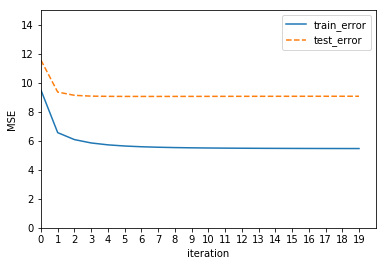

In [22]:
# 반복에 따른 학습-평가 에러변화 출력(평가에러: 점선, 학습에러: 실선)
# 훈연을 반복할수록 test 의 MSE도 감소합니다
x = range(0,20)
plt.xlim(0,20); plt.xlabel('iteration'); plt.xticks(x, range(0,20));
plt.ylim(0,15); plt.ylabel('MSE')
plt.plot(x,train_errors,      label='train_error')
plt.plot(x,test_errors, '--', label='test_error')
plt.legend() #handles=[train_plot, test_plot]); 
plt.show()

### **03 위에서 생성한 근사 모델을 활용한 추천**
- 사용자 ID를 입력받아서 **근사모델**을 활용한 **추천영화**를 출력합니다
- 기존의 별점과 동일한 환경을 위해 **0~5 사이의 값으로 정규화** 합니다

In [23]:
%%time
# 최솟값 0: 전체에 최소값을 뺀다 (X, Y를 0~5의 수로 초기화)
# 큰 값 5: 최대 예측값(np.max(R_hat))으로 나눈 값을 곱합니다.
R_hat -= np.min(R_hat)
R_hat *= float(5) / np.max(R_hat)

# 사용자의 ID 입력, 보지 않은 영화 중 추천합니다.
def recommend_by_user(user):
    user_index       = user - 1
    user_seen_movies = sorted(list(enumerate(R_hat[user_index])),key=lambda x:x[1], reverse=True)
    recommended      = 1
    print("----- {} 관람객 추천영화 ------".format(" ".join(user_info_li[0][:-1])))
    for movie_info in user_seen_movies:
        if W[user][movie_info[0]] == 0:
            movie_title = movie_info_li[int(movie_info[0]+1)]
            movie_score = movie_info[1]
            print("%d 순위 추천영화: 평점(%.3f) %s"%(recommended, movie_score, movie_title[0]))
            recommended += 1
        if recommended == 6: break

recommend_by_user(1)

----- 24 M technician 관람객 추천영화 ------
1 순위 추천영화: 평점(3.998) Brazil (1985)
2 순위 추천영화: 평점(3.944) Wrong Trousers, The (1993)
3 순위 추천영화: 평점(3.913) So I Married an Axe Murderer (1993)
4 순위 추천영화: 평점(3.702) Priest (1994)
5 순위 추천영화: 평점(3.627) GoodFellas (1990)
CPU times: user 7.24 ms, sys: 15.8 ms, total: 23 ms
Wall time: 7.63 ms
